In [5]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, SAGEConv, NNConv, GCNConv
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec

torch.manual_seed(42)

In [6]:
%run dataset_nc.ipynb

DATASET LOADED
EnterpriseModelDatasetNC(110)


Processing...
Done!


In [7]:
dataset_nc

EnterpriseModelDatasetNC(110)

In [8]:
torch.manual_seed(42)
dataset = dataset_nc.shuffle()

train_dataset = dataset[:int(len(dataset) * 1)]

print(f'Number of graphs total: {len(dataset)}')
print(f'Number of training graphs: {len(train_dataset)}')
print(dataset[0])

Number of graphs total: 110
Number of training graphs: 110
Data(x=[26, 1], edge_index=[2, 25], edge_attr=[25, 1], y=[26], train_mask=[26], test_mask=[26])


In [9]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

NUM_GRAPHS_PER_BATCH = len(dataset)
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [10]:
x = []
edge_index = []
edge_attr = []
y = []
train_mask = []
test_mask = []
for batch in train_loader:
    x = batch.x
    edge_index = batch.edge_index
    edge_attr = batch.edge_attr
    y = batch.y
    train_mask = batch.train_mask
    test_mask = batch.test_mask

data = Data(x=x, 
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            train_mask=train_mask,
            test_mask=test_mask
            ) 

num_nodes = data.x.shape[0]
print(data)

Data(x=[3020, 1], edge_index=[2, 3216], edge_attr=[3216, 1], y=[3020], train_mask=[3020], test_mask=[3020])


In [11]:
embedding_dim = 8

Epoch: 01, Loss: 1.6661, Acc: 0.1767
Epoch: 02, Loss: 1.3082, Acc: 0.1728
Epoch: 03, Loss: 1.1232, Acc: 0.1728
Epoch: 04, Loss: 1.0134, Acc: 0.1741
Epoch: 05, Loss: 0.9467, Acc: 0.1728
Epoch: 06, Loss: 0.9033, Acc: 0.1780
Epoch: 07, Loss: 0.8749, Acc: 0.1675
Epoch: 08, Loss: 0.8543, Acc: 0.1702
Epoch: 09, Loss: 0.8405, Acc: 0.1688
Epoch: 10, Loss: 0.8291, Acc: 0.1623
Epoch: 11, Loss: 0.8216, Acc: 0.1636
Epoch: 12, Loss: 0.8155, Acc: 0.1636
Epoch: 13, Loss: 0.8108, Acc: 0.1597
Epoch: 14, Loss: 0.8070, Acc: 0.1584
Epoch: 15, Loss: 0.8042, Acc: 0.1558
Epoch: 16, Loss: 0.8016, Acc: 0.1597
Epoch: 17, Loss: 0.7998, Acc: 0.1571
Epoch: 18, Loss: 0.7983, Acc: 0.1545
Epoch: 19, Loss: 0.7963, Acc: 0.1558
Epoch: 20, Loss: 0.7959, Acc: 0.1623
Epoch: 21, Loss: 0.7943, Acc: 0.1571
Epoch: 22, Loss: 0.7942, Acc: 0.1584
Epoch: 23, Loss: 0.7925, Acc: 0.1531
Epoch: 24, Loss: 0.7929, Acc: 0.1623
Epoch: 25, Loss: 0.7919, Acc: 0.1597
Epoch: 26, Loss: 0.7914, Acc: 0.1584
Epoch: 27, Loss: 0.7914, Acc: 0.1571
E

C:\Users\alber\anaconda3\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\alber\anaconda3\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


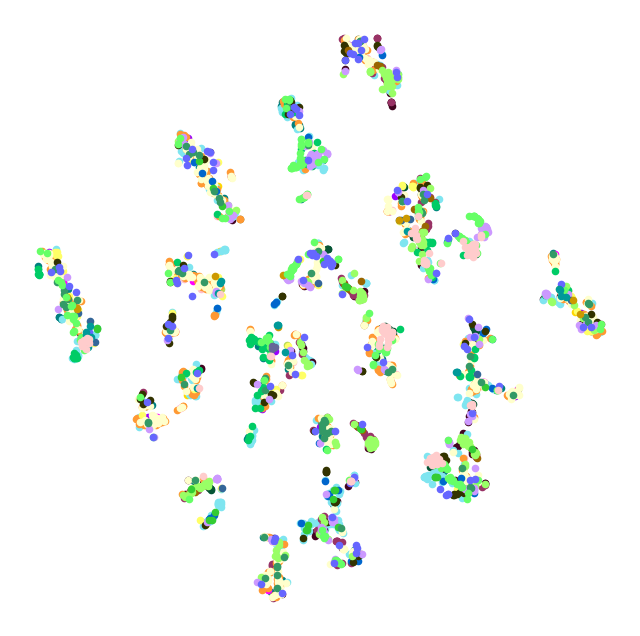

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=embedding_dim, walk_length=15,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

num_workers = 0
loader = model.loader(batch_size=64, shuffle=True,
                      num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

acc_values = []
loss_values = []
for epoch in range(1, 101):
    loss = train()
    acc = test()
    loss_values.append(loss)
    acc_values.append(acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    

plt.plot(loss_values, 'r',)
plt.show()
plt.plot(acc_values, 'b',)
plt.show()

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700', '#9900ff', '#008080', '#420420', '#7fe5f0', '#065535',
    '#008080', '#420420', '#7fe5f0', '#ff00ff', '#993366', '#ff5050',
    '#ff9933', '#ffff66', '#ffffcc', '#0066cc', '#00cc66', '#333300',
    '#996600', '#99ff66', '#cc99ff', '#336699', '#33cc33', '#339966',
    '#cc9900', '#66ff66', '#6666ff', '#009999', '#666699', '#ffcccc',
]
plot_points(colors)

In [13]:
z = model()
z[0]

tensor([-0.3557,  0.7964,  0.3033,  0.3511,  0.0423,  0.4161, -1.3706,  0.3252],
       grad_fn=<SelectBackward0>)

In [14]:
embeddings = []
for emb in z:
    new = []
    for val in emb:
        new.append(val.item())
    embeddings.append(new)

len(embeddings)

3020

In [15]:
data_emb = []
i = 0
for graph in dataset:
    emb = []
    edge_index = graph.edge_index
    edge_attr = graph.edge_attr
    y = graph.y
    train_mask = graph.train_mask
    test_mask = graph.test_mask
    for j, _ in enumerate(graph.x):
        emb.append(embeddings[i])
        i += 1
        
    new_data = Data(x=torch.tensor(emb, dtype=torch.float), 
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            train_mask=train_mask,
            test_mask=test_mask
            )
    data_emb.append(new_data)

In [16]:
data_emb[0].x.shape[1]

8

In [17]:
dataset = data_emb

train_dataset = dataset[:int(len(dataset) * 1)]

print(f'Number of graphs total: {len(dataset)}')
print(f'Number of training graphs: {len(train_dataset)}')
print(dataset[0])

Number of graphs total: 110
Number of training graphs: 110
Data(x=[26, 8], edge_index=[2, 25], edge_attr=[25, 1], y=[26], train_mask=[26], test_mask=[26])


In [18]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

NUM_GRAPHS_PER_BATCH = 8
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [23]:
class GATGNN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(embedding_dim, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(embedding_dim, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv2 = GATConv(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv3 = GATConv(4 * NUM_HIDDEN_CHANNELS, len(node_classes), heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, len(node_classes))

        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.elu(self.conv1(x, edge_index, edge_attr) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_attr) + self.lin2(x))
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        return F.log_softmax(x, dim=1)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN2().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GATGNN2(
  (conv1): GATConv(8, 64, heads=4)
  (lin1): Linear(in_features=8, out_features=256, bias=True)
  (conv2): GATConv(256, 64, heads=4)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 36, heads=6)
  (lin3): Linear(in_features=256, out_features=36, bias=True)
)
Number of parameters:  203688


In [25]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [26]:
@torch.no_grad()
def test():
    model.eval()

    total_acc = 0
    for data in train_loader:
        pred = model(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        total_acc += acc * data.num_graphs
    return total_acc / len(train_loader.dataset)

Epoch: 001, Loss: 4.3327, Acc: 0.1383,
Epoch: 002, Loss: 3.7909, Acc: 0.1345,
Epoch: 003, Loss: 3.2387, Acc: 0.1384,
Epoch: 004, Loss: 3.2108, Acc: 0.1608,
Epoch: 005, Loss: 2.9235, Acc: 0.1797,
Epoch: 006, Loss: 2.7922, Acc: 0.1461,
Epoch: 007, Loss: 2.8293, Acc: 0.1810,
Epoch: 008, Loss: 2.8025, Acc: 0.1896,
Epoch: 009, Loss: 2.7418, Acc: 0.1519,
Epoch: 010, Loss: 2.7075, Acc: 0.2133,
Epoch: 011, Loss: 2.6152, Acc: 0.1841,
Epoch: 012, Loss: 2.5678, Acc: 0.1870,
Epoch: 013, Loss: 2.4810, Acc: 0.2244,
Epoch: 014, Loss: 2.4025, Acc: 0.2227,
Epoch: 015, Loss: 2.4219, Acc: 0.2557,
Epoch: 016, Loss: 2.2929, Acc: 0.2299,
Epoch: 017, Loss: 2.3010, Acc: 0.2394,
Epoch: 018, Loss: 2.3276, Acc: 0.2374,
Epoch: 019, Loss: 2.2423, Acc: 0.2688,
Epoch: 020, Loss: 2.2926, Acc: 0.2263,
Epoch: 021, Loss: 2.2558, Acc: 0.2630,
Epoch: 022, Loss: 2.1642, Acc: 0.2404,
Epoch: 023, Loss: 2.1024, Acc: 0.2496,
Epoch: 024, Loss: 2.0806, Acc: 0.2575,
Epoch: 025, Loss: 2.0257, Acc: 0.2355,
Epoch: 026, Loss: 2.1193,

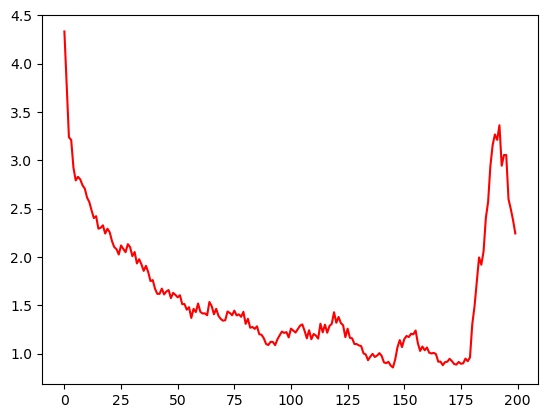

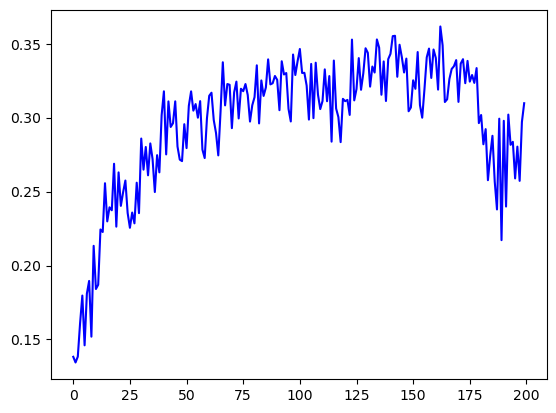

In [27]:
loss_values = []
acc_values = []

for epoch in range(1, 201):
    loss = train()
    acc = test()
    
    loss_values.append(loss)
    acc_values.append(acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Acc: {acc:.4f},')
    if(acc > 0.61): break

plt.plot(loss_values, 'r',)
plt.show()
plt.plot(acc_values, 'b',)
plt.show()